This based off of the tutorial from scanpy using pbmc 3K.
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

And heavily influenced by https://github.com/theislab/scanpy_usage/blob/master/170503_zheng17/zheng17.ipynb

We are interesting in doing 1month vs 30month, male kidney

In [72]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from matplotlib.pyplot import rc_context

import os

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.23.5 scipy==1.8.1 pandas==1.5.3 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


## Open files

In [73]:
data_path = f"{os.getcwd()}/../../data/bulk_data/covid/"
ref_path = f"{os.getcwd()}/../../data/reference_data/"


# files from geneomnibus
in_file = f"{data_path}/GSE198449_featureCounts.txt"
meta_file = f"{data_path}/GSE198449_PCR_and_Symptoms_Full_Info.csv"
genes_file = f"{ref_path}/biomart_grch38.p13_geneids.txt"
results_file = f"{data_path}/covid_bulk_processed.h5ad"

with open(in_file) as your_data:
    adata = ad.read_csv(your_data, delimiter='\t')
    adata = adata.transpose()
    
# process the sample names to match metadata
new_idx = [x.split("_P", 1)[0] for x in adata.obs_names.to_list()]
adata.obs = pd.DataFrame(new_idx)

# add in all the metadata
obs_df = pd.read_csv(meta_file)
obs_df = obs_df.set_index(obs_df["biocollection ID"])
obs_df = obs_df.loc[adata.obs[0]]

# we need to edit gene names
new_idx = [x.split(".", 1)[0] for x in adata.var_names.to_list()]
var_df = pd.DataFrame(new_idx)
var_df.columns = ["ens_gene_id"]

# remake anndata
adata = ad.AnnData(adata.X, obs=obs_df, var=var_df)
adata

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 1858 × 58929
    obs: 'enrollment batch', 'biocollection ID', 'participant ID', 'sample collection time point (days since T0)', 'PCR test for SARS-Cov-2', 'symptom'
    var: 'ens_gene_id'

In [74]:
# read in reference gene info
gene_ref_df = pd.read_csv(genes_file, sep="\t")
gene_ref_df.columns = ["ens_gene_id", "ens_gene_id_version", "gene_name"]
gene_ref_df = gene_ref_df.set_index("ens_gene_id")
gene_ref_df = gene_ref_df.dropna()

# get genes that have a reference name
common_genes = np.intersect1d(gene_ref_df.index.to_list(), adata.var["ens_gene_id"])

# merge the var data into adata
adata = adata[:,adata.var.ens_gene_id.isin(common_genes)]
new_var_df = pd.merge(adata.var, gene_ref_df, on="ens_gene_id")
new_var_df = new_var_df.set_index("ens_gene_id")


In [75]:
# make sure the indices didn't get out of order
adata.var.ens_gene_id.to_list() == new_var_df.index.to_list()


True

In [76]:
# set the new gene names
new_var_df = new_var_df.set_index("gene_name")
adata.var = new_var_df

adata.var

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


,ens_gene_id_version
gene_name,
TSPAN6,ENSG00000000003.15
TNMD,ENSG00000000005.6
DPM1,ENSG00000000419.14
SCYL3,ENSG00000000457.14
C1orf112,ENSG00000000460.17
...,...
COPG2IT1,ENSG00000286214.1
LINC00279,ENSG00000286217.2
NOTCH2NLC,ENSG00000286219.2


In [77]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata.obs_names_make_unique()  


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(


In [78]:
adata.obs

,enrollment batch,biocollection ID,participant ID,sample collection time point (days since T0),PCR test for SARS-Cov-2,symptom
biocollection ID,,,,,,
20_5063-T00,Initial Outbreak,20_5063-T00,5063,0,NaN,NaN
20_5134-T00,Initial Outbreak,20_5134-T00,5134,0,NaN,rn_nose
20_5218-T00,Initial Outbreak,20_5218-T00,5218,0,NaN,NaN
20_5246-T00,Initial Outbreak,20_5246-T00,5246,0,NaN,NaN
20_5326-T00,Initial Outbreak,20_5326-T00,5326,0,NaN,NaN
...,...,...,...,...,...,...
20_9153-T63,Later Surveillance,20_9153-T63,9153,63,Not,NaN
20_9520-T00-9,Initial Outbreak,20_9520-T00,9520,0,NaN,fatigue
20_9719-T00-1,Later Surveillance,20_9719-T00,9719,0,Not,NaN


In [79]:
# subset to only where there is a PCR test
adata = adata[np.where(np.isin(adata.obs["PCR test for SARS-Cov-2"], ["Detected", "Not"]))]

# how many of each participant with a test
tab = adata.obs.groupby(['participant ID', 'PCR test for SARS-Cov-2']).size()

tab.unstack()

PCR test for SARS-Cov-2,Detected,Not
participant ID,,
5002,NaN,11.0
5011,1.0,3.0
5012,NaN,1.0
5023,1.0,2.0
5035,NaN,1.0
...,...,...
9937,2.0,3.0
9940,2.0,6.0
9943,1.0,3.0


## format the obs for BuDDI

In [81]:
# now make pairings of samples


# Initialize metadata in expected format
adata.obs['sample_id'] = adata.obs["participant ID"]


def get_stim_id(in_str):
    out_str = "STIM"
    if in_str == "Not":
        out_str = "CTRL"
           
    return(out_str)

adata.obs['stim'] = [get_stim_id(str(x)) for x in adata.obs["PCR test for SARS-Cov-2"].tolist()]
adata.var['gene_ids'] = adata.var.index.tolist()


In [82]:
# how many of each mouse
tab = adata.obs.groupby(['stim', 'sample_id']).size()
tab.unstack()

sample_id,5002,5011,5012,5023,5035,5038,5039,5054,5061,5063,...,9880,9914,9918,9920,9931,9937,9940,9943,9995,9997
stim,,,,,,,,,,,,,,,,,,,,,
CTRL,11.0,3.0,1.0,2.0,1.0,1.0,4.0,3.0,1.0,1.0,...,4.0,10.0,2.0,2.0,6.0,3.0,6.0,3.0,1.0,3.0
STIM,NaN,1.0,NaN,1.0,NaN,2.0,4.0,1.0,1.0,NaN,...,NaN,2.0,4.0,2.0,1.0,2.0,2.0,1.0,1.0,3.0


## Preprocessing

normalizing counts per cell
    finished (0:00:00)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


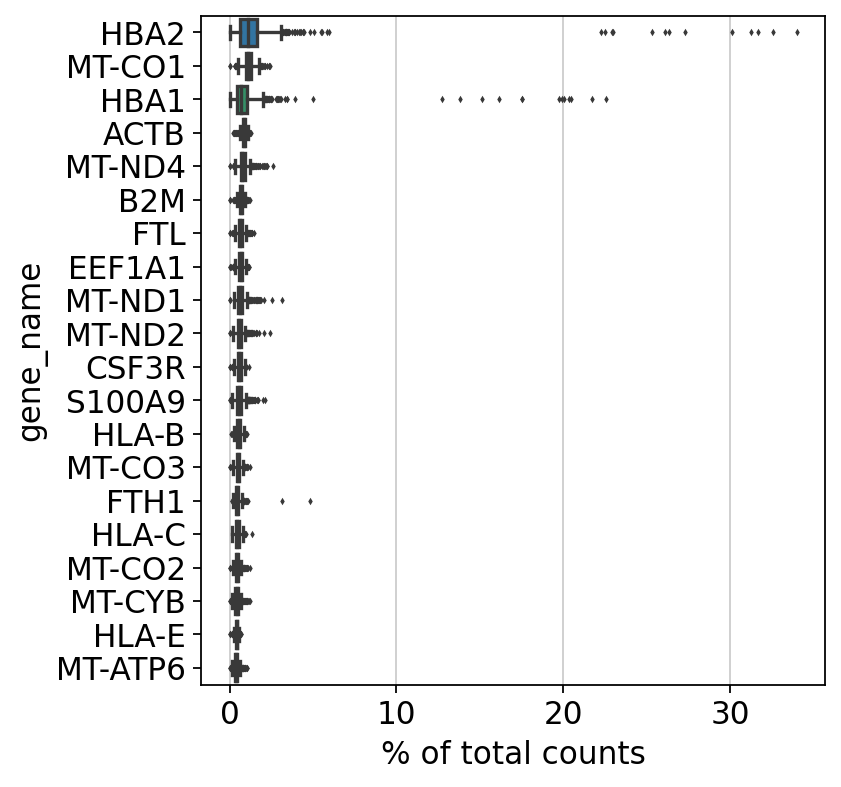

In [83]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [84]:
results_file

'/beevol/home/davidson/checkouts/sc_bulk_ood/sc_preprocessing/0_qc_notebooks/../../data/bulk_data/covid//covid_bulk_processed.h5ad'

In [85]:
# write it out before normalization
del adata.raw
adata.write(results_file)


extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


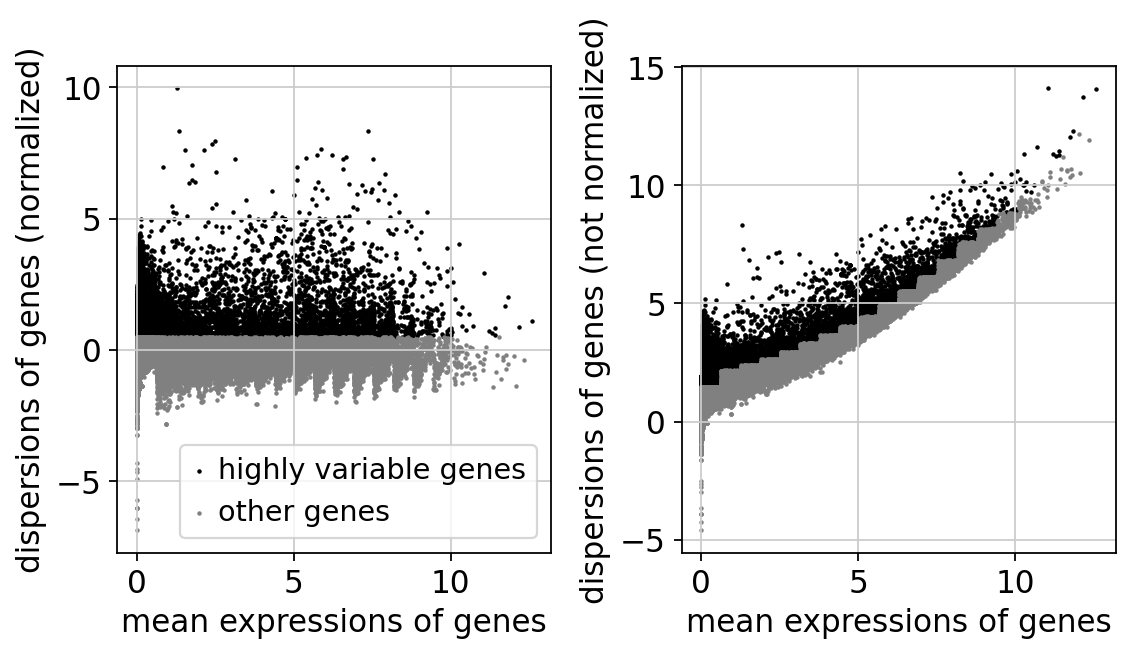

In [86]:
# normalize to 10K counts per cell
#sc.pp.normalize_total(adata, target_sum=1e6)

# log data
sc.pp.log1p(adata)

# get high variance genes
sc.pp.highly_variable_genes(adata, min_mean=0, max_mean=15, min_disp=0.5)

# and plot
sc.pl.highly_variable_genes(adata)

# now store the raw version of the data for our use later
#adata.raw = adata


In [87]:
# now process the counts further for doing DE 
# analysis and the cell clustering
adata = adata[:, adata.var.highly_variable]

# scale the genes
sc.pp.scale(adata, max_value=20)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


## PCA

In [88]:
sc.tl.pca(adata, n_comps=10)
sc.pp.neighbors(adata)
sc.tl.tsne(adata)


computing PCA
    on highly variable genes
    with n_comps=10
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing tSNE
    using 'X_pca' with n_pcs = 10
    using sklearn.manifold.TSNE


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:05)


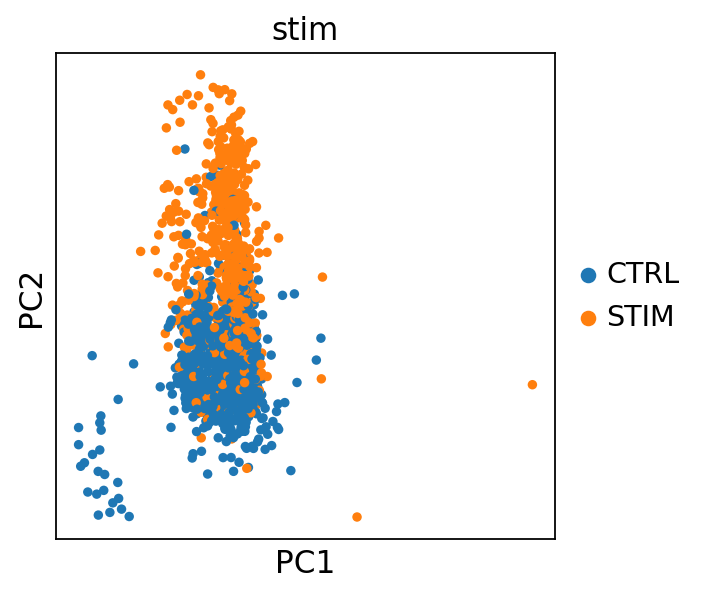

In [90]:
sc.pl.pca(adata, color="stim")

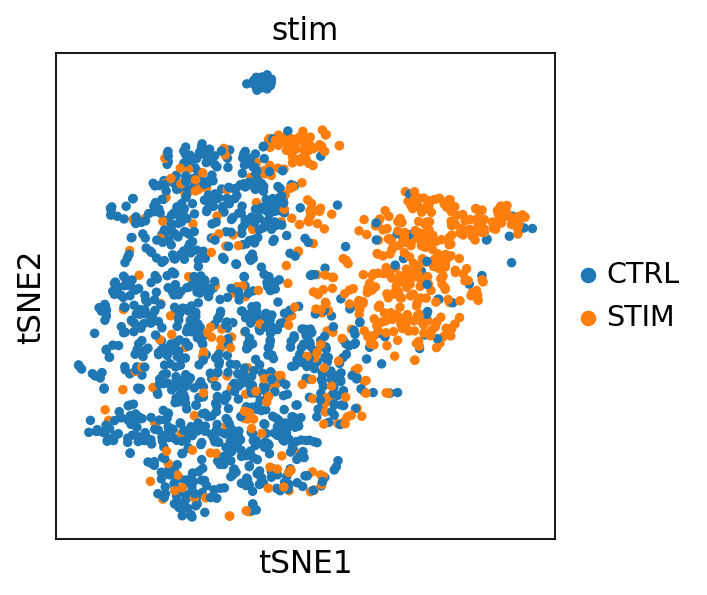

In [89]:
sc.pl.tsne(adata, color="stim")

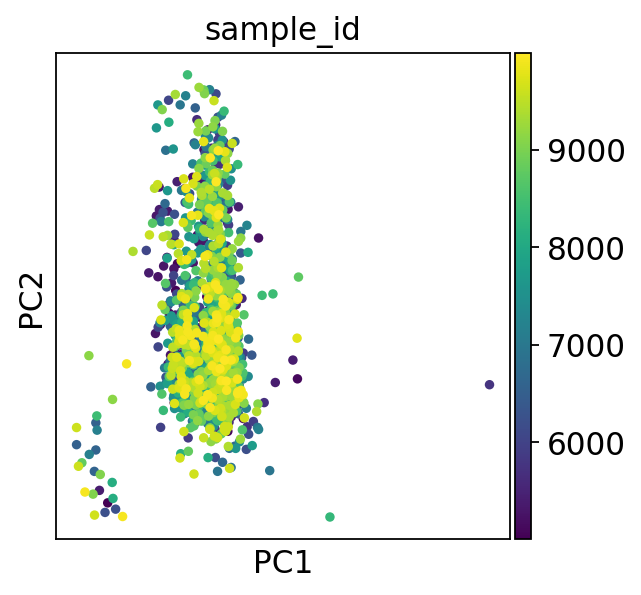

In [91]:
sc.pl.pca(adata, color="sample_id")

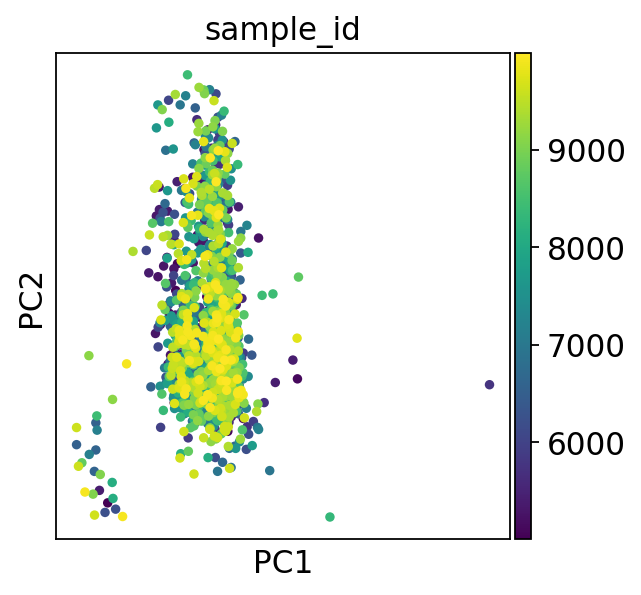

In [92]:
sc.pl.pca(adata, color="sample_id")

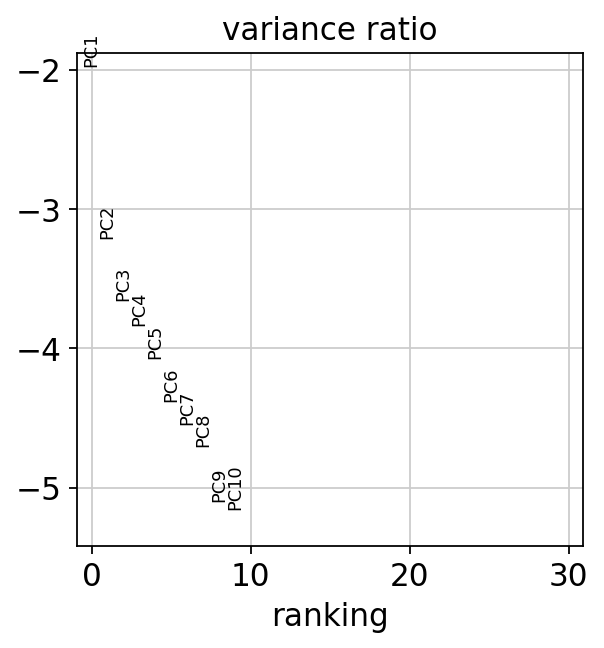

In [93]:
sc.pl.pca_variance_ratio(adata, log=True)



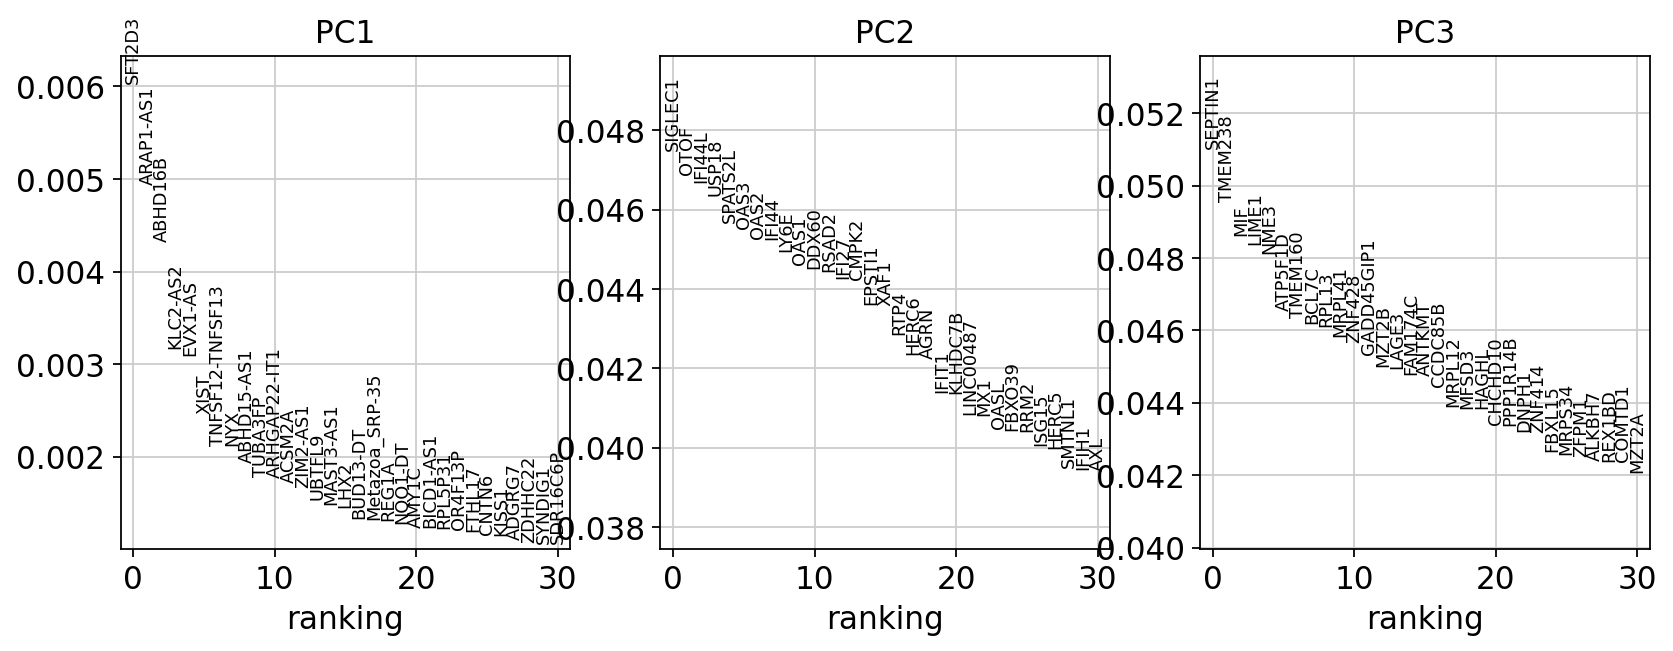

In [94]:
sc.pl.pca_loadings(adata, include_lowest=False)
